In [1]:
import ROOT as r
import math
import array
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

#______________Add include directory_______________
current_dir = os.getcwd()
include_dir = os.path.join(current_dir, '../include')
sys.path.insert(0, include_dir)
#__________________________________________________

import CONFIG
import DBPARSE
from UTILITIES import *
from SIMFITS import DistributionFits
from ROOT import gStyle, TChain, TH1F, TCanvas, TLegend
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy.optimize import curve_fit
from scipy.integrate import quad


Welcome to JupyROOT 6.26/06


In [2]:
pas="1"
config="4"


In [3]:
W2min=CONFIG.Function_JSON("W2min",f"../config/cuts{config}.cfg")
W2max=CONFIG.Function_JSON("W2max",f"../config/cuts{config}.cfg")
dxmin=CONFIG.Function_JSON("dxmin",f"../config/cuts{config}.cfg")
dxmax=CONFIG.Function_JSON("dxmax",f"../config/cuts{config}.cfg")
dymin=CONFIG.Function_JSON("dymin",f"../config/cuts{config}.cfg")
dymax=CONFIG.Function_JSON("dymax",f"../config/cuts{config}.cfg")
dybgmin=CONFIG.Function_JSON("dybgmin",f"../config/cuts{config}.cfg")
dybgmax=CONFIG.Function_JSON("dybgmax",f"../config/cuts{config}.cfg")
coinmin=CONFIG.Function_JSON("coinmin",f"../config/cuts{config}.cfg")
coinmax=CONFIG.Function_JSON("coinmax",f"../config/cuts{config}.cfg")

print(f'W2min: {W2min}')
print(f'W2max: {W2max}')
print(f'dxmin: {dxmin}')
print(f'dxmax: {dxmax}')
print(f'dymin: {dymin}')
print(f'dymax: {dymax}')
print(f'dybgmin: {dybgmin}')
print(f'dybgmax: {dybgmax}')
print(f'Coin Min: {coinmin} Coin Max: {coinmax}')

W2min: -1
W2max: 2
dxmin: -0.303
dxmax: 0.306
dymin: -0.84
dymax: 0.984
dybgmin: -1.4
dybgmax: 1.4
Coin Min: 81 Coin Max: 100


# GEN2

Number of Total events: 15084
Number of Protons events: 320
Number of Neutron events: 3920
Number of Background events: 10843
Fraction: fp=0.021 fbg=0.71884
Fraction of Neutrons 0.26


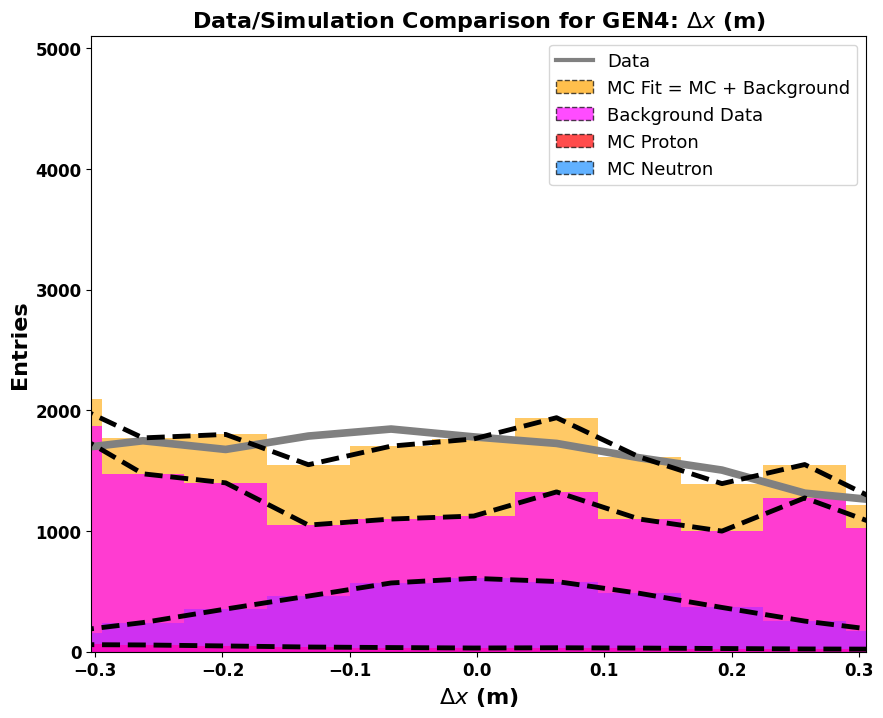

In [4]:

save=np.load(f'SavedArrays/GEN{config}/Pass1/GEN{config}simfit1.npy',allow_pickle=True).item()

data=save['data']
bgHist=save['bgHist']
totalHist=save['totalHist']
simpHist=save['simpHist']
simnHist=save['simnHist']

sigCut=2
plt.figure(figsize=(10,8))
lw=3.5
fs=16
fw='bold'


#____________Data___________________________________________________________________________________________
bin_centers,bin_contents=data
plt.plot(bin_centers, bin_contents,'-',color='grey',linewidth=lw+2,label='Data')
#___________________________________________________________________________________________________________



#____________Total Fit = SimP + SimN + Background___________________________________________________________
bin_centers,bin_contents=totalHist
plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.6,color='orange',label="Total Fit = bg+simN+simP")
plt.plot(bin_centers, bin_contents,'--',color='black',linewidth=lw)
#___________________________________________________________________________________________________________



#____________Simulated Neutron______________________________________________________________________________
bin_centers,bin_contents=simnHist
plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.7,color="dodgerblue",label="MC Neutron")
plt.plot(bin_centers, bin_contents,'--',color='black',linewidth=lw)
#___________________________________________________________________________________________________________


#____________Simulated Proton_______________________________________________________________________________
bin_centers,bin_contents=simpHist
plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.8,color="red",label="MC Proton")
plt.plot(bin_centers, bin_contents,'--',color='black',linewidth=lw)
#___________________________________________________________________________________________________________

#____________Background_____________________________________________________________________________________
bin_centers,bin_contents=bgHist
plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.7,color='magenta',label="Background Data")
plt.plot(bin_centers, bin_contents,'--',color='black',linewidth=lw)
#___________________________________________________________________________________________________________



#____________________________vertical bars for quasi cut_____________________________________________-
#
bin_centers,bin_contents=simnHist

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

initial_guess = [max(bin_contents), bin_centers[np.argmax(bin_contents)], 1.0]

popt, pcov = curve_fit(gaussian, bin_centers, bin_contents, p0=initial_guess)

amplitude, mean, stddev = popt

x_fit = np.linspace(min(bin_centers), max(bin_centers), 100)
y_fit = gaussian(x_fit, *popt)
#plt.axvline(mean - sigCut * stddev, color='red', linewidth=4, label=f'$\mu - {sigCut}\sigma$')
#plt.axvline(mean + sigCut * stddev, color='red', linewidth=4, label=f'$\mu + {sigCut}\sigma$')
#________________________________________________________________________________________________________________
#_________________Special Legend Including Dotted Black Border______________________________________________
a=.7
legend_elements = [
    Line2D([0], [0], color='grey', linewidth=3, linestyle='-', label='Data'),
    Patch(facecolor='orange', edgecolor='black', linestyle='--', label='MC Fit = MC + Background', alpha=a),
    Patch(facecolor='magenta', edgecolor='black', linestyle='--', label='Background Data', alpha=a),
    Patch(facecolor='red', edgecolor='black', linestyle='--', label='MC Proton', alpha=a),
    Patch(facecolor='dodgerblue', edgecolor='black', linestyle='--', label='MC Neutron', alpha=a)
]
#___________________________________________________________________________________________________________
#plt.axvline(mean - sigCut * stddev, color='black', linewidth=3,ymax=.4,ymin=0.05,label=f'$\mu - {sigCut}\sigma$')
#plt.axvline(mean + sigCut * stddev, color='black', linewidth=3,ymax=.4,ymin=.05, label=f'$\mu + {sigCut}\sigma$')


#_________________________________Calculate Fractions_______________________
lower_bound = dxmin
upper_bound = dxmax

bin_centers,bin_contents=bgHist
numBG=np.sum(bin_contents[(bin_centers >= lower_bound) & (bin_centers <= upper_bound)])

bin_centers,bin_contents=simpHist
numProton=np.sum(bin_contents[(bin_centers >= lower_bound) & (bin_centers <= upper_bound)])

bin_centers,bin_contents=simnHist
numNeutron=np.sum(bin_contents[(bin_centers >= lower_bound) & (bin_centers <= upper_bound)])

bin_centers,bin_contents=totalHist
numTotal=np.sum(bin_contents[(bin_centers >= lower_bound) & (bin_centers <= upper_bound)])

#___________________________________________________________________________
plt.xlim((dxmin,dxmax))
plt.ylim((0,np.max(totalHist[1]*1)))
plt.title(f'Data/Simulation Comparison for GEN{config}: $\Delta x$ (m)',fontsize=fs,fontweight=fw)
plt.legend(handles=legend_elements,loc='upper right',fontsize=fs-3)
plt.xticks(fontsize=fs-4, fontweight=fw)
plt.yticks(fontsize=fs-4, fontweight=fw)
plt.xlabel(r'$\Delta x$ (m)',fontsize=fs,fontweight=fw)
plt.ylabel('Entries',fontsize=fs,fontweight=fw)

print(f'Number of Total events: {int(numTotal)}')
print(f'Number of Protons events: {int(numProton)}')
print(f'Number of Neutron events: {int(numNeutron)}')
print(f'Number of Background events: {int(numBG)}')
print(f'Fraction: fp={np.round(numProton/numTotal,3)} fbg={np.round(numBG/numTotal,5)}')
fproton=np.round(numProton/numTotal,3)
fbg=np.round(numBG/numTotal,3)
np.save(f'CorrectionArrays/Pass{pas}/fproton{config}.npy',np.array(fproton))
np.save(f'CorrectionArrays/Pass{pas}/fbg{config}.npy',np.array(fbg))

print(f'Fraction of Neutrons {np.round(numNeutron/numTotal,3)}')